In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix

from implicit import als

from lightgbm import LGBMClassifier

from sklearn.metrics import precision_recall_curve, roc_auc_score

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
sys.path.append('../webinar_4/')    

from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('../webinar_2/retail_train.csv')
item_features = pd.read_csv('../webinar_2/product.csv')
user_features = pd.read_csv('../webinar_2/hh_demographic.csv')

In [3]:
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [4]:
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - val_lvl_2_size_weeks)]
data_train_lvl_2 = data_val_lvl_1.copy()
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_val_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.0,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,0.0,0.0


In [5]:
n_items_before = data_train_lvl_1['item_id'].nunique()

top_5000 = data_train_lvl_1.groupby('item_id')['quantity'].sum().reset_index()\
    .sort_values('quantity', ascending=False).head(5000).item_id.tolist()
data_train_lvl_1.loc[~data_train_lvl_1['item_id'].isin(top_5000), 'item_id'] = 999999

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [6]:
recommender = MainRecommender(data_train_lvl_1)

In [7]:
recommender

In [8]:
recommender.get_als_recommendations(2375, N=5)

[1082185, 981760, 923746, 904360, 1044078]

In [9]:
recommender.get_own_recommendations(2375, N=5)

[1082185, 1098066, 1127831, 1004906, 1081177]

In [10]:
recommender.get_similar_items_recommendation(2375, N=5)

[857697, 889731, 1081177, 1046545, 899624]

In [11]:
recommender.get_similar_users_recommendation(2375, N=5)

[6534178, 1082185, 1029743, 1098066, 995785]

---

### Измеряем recall@k

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?

In [12]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()\
    .rename(columns={'item_id': 'actual'})
result_lvl_1.head(3)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67..."


In [13]:
result_lvl_1 = result_lvl_1[result_lvl_1['user_id'].isin(data_train_lvl_1['user_id'].unique())]

In [14]:
k=50

In [15]:
result_lvl_1['own'] = result_lvl_1['user_id'].apply(
    lambda x: recommender.get_own_recommendations(x, N=k))

In [16]:
result_lvl_1['als'] = result_lvl_1['user_id'].apply(
    lambda x: recommender.get_als_recommendations(x, N=k))

In [17]:
result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(
    lambda x: recommender.get_similar_items_recommendation(x, N=k))

In [18]:
result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(
    lambda x: recommender.get_similar_users_recommendation(x, N=k))

In [19]:
pd.DataFrame(
    pd.Series({
        col: round(result_lvl_1.apply(
            lambda row: recall_at_k(row[col], row['actual'], k=50),
            axis=1).mean(), 4) for col in result_lvl_1.columns[2:].tolist()
    }), 
    columns=['recall_at_k']
)

,recall_at_k
own,0.0920
als,0.1062
similar_items,0.0570
similar_users,0.0668


Лучший recall дают als recommendtions + top-popular

---

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}

In [20]:
d = {}
k_list = [20, 50, 100, 200, 500]
for k in k_list:
    result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=k))
    result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=k))
    result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=k))
    result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=k))
    d[f'recall_at_{k}'] = {col: round(result_lvl_1.apply(lambda row: recall_at_k(row[col], row['actual'], k=k), axis=1).mean(), 4) for col in result_lvl_1.columns[2:].tolist()}
df = pd.DataFrame(d)
df

,recall_at_20,recall_at_50,recall_at_100,recall_at_200,recall_at_500
own,0.0589,0.0920,0.1247,0.1487,0.1570
als,0.0637,0.1062,0.1483,0.2002,0.2928
similar_items,0.0352,0.0570,0.0790,0.1031,0.1251
similar_users,0.0450,0.0668,0.0875,0.1149,0.1622


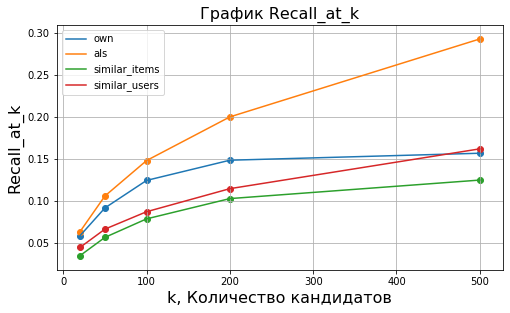

In [21]:
plt.figure(figsize=(8, 4.5))
x = k_list
for ind in df.index:
    y = df.loc[ind].tolist()
    plt.plot(x, y, label=ind)
    plt.scatter(x, y)
plt.title('График Recall_at_k',  fontsize=16)
plt.xlabel('k, Количество кандидатов', fontsize=16)
plt.ylabel('Recall_at_k', fontsize=16)
plt.legend(loc='upper left')
plt.grid()
plt.show()

C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

* Для моделей: own, similar_items, similar_users - значение k=200 будет являться оптимальным, т.к. дальнейшее увеличение количества кандидатов не дает существенные прирост в метрике.
* Для модели als значение k=500 является оптимальным, потому что метрика имеет максимальное значение

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_lvl_2
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [22]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique(),
                           columns = ['user_id'])
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]
users_lvl_2['candidates'] = users_lvl_2['user_id']\
    .apply(lambda x: recommender.get_own_recommendations(x, N=20))
users_lvl_2.head(3)

,user_id,candidates
0,2070,"[1082185, 1029743, 1098066, 1127831, 6534178, ..."
1,2021,"[1098066, 995785, 1004906, 1081177, 1044078, 1..."
2,1753,"[1082185, 6534178, 1004906, 1044078, 1133018, ..."


In [23]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(3)

/home/sergey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


,user_id,item_id,flag
0,2070,1082185.0,1
0,2070,1029743.0,1
0,2070,1098066.0,1


In [24]:
users_lvl_2['user_id'].nunique()

2153

In [25]:
target_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
target_lvl_2['target'] = 1

target_lvl_2 = users_lvl_2.merge(target_lvl_2, on=['user_id', 'item_id'], how='left')
target_lvl_2 = target_lvl_2[~target_lvl_2.duplicated()]
target_lvl_2['target'].fillna(0, inplace=True)
target_lvl_2.drop('flag', axis=1, inplace=True)

target_lvl_2.head(3)

,user_id,item_id,target
0,2070,1082185.0,1.0
1,2070,1029743.0,0.0
2,2070,1098066.0,0.0


In [26]:
target_lvl_2.shape

(41728, 3)

In [27]:
target_lvl_2['target'].mean()

0.14273389570552147

In [28]:
data.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


---

In [29]:
# Средний чек
avg_chek = data.groupby('user_id')['sales_value', 'basket_id']\
    .agg({'sales_value': np.sum, 'basket_id': 'count'})
avg_chek['avg_chek'] = avg_chek['sales_value'] / avg_chek['basket_id']
avg_chek.drop(['sales_value', 'basket_id'], axis=1, inplace=True)
avg_chek.head(3)

/home/sergey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,avg_chek
user_id,
1,2.492077
2,2.783893
3,2.918223


In [30]:
# Средняя сумма покупки 1 товара в каждой категории для каждого user_а
user_dep = data\
    .join(item_features[['item_id', 'department']].set_index('item_id'), on='item_id')\
    .groupby(['user_id', 'department'])['quantity', 'sales_value']\
    .agg({'quantity': np.sum, 'sales_value': np.sum})
user_dep['avg_sum_purchase_one_item_id_by_department'] = user_dep['sales_value'] / user_dep['quantity']
user_dep.drop(columns=['quantity', 'sales_value'], inplace=True)
user_dep.dropna(axis=0, inplace=True)
user_dep.reset_index('department', inplace=True)
user_dep = user_dep.pivot_table(
    index='user_id', columns='department', 
    values='avg_sum_purchase_one_item_id_by_department', 
    aggfunc='sum', fill_value=0)
user_dep.columns = [f'{col}_avg_cost_by_user' for col in user_dep.columns]
user_dep.head(3)

/home/sergey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,AUTOMOTIVE_avg_cost_by_user,CHARITABLE CONT_avg_cost_by_user,CHEF SHOPPE_avg_cost_by_user,CNTRL/STORE SUP_avg_cost_by_user,COSMETICS_avg_cost_by_user,COUP/STR & MFG_avg_cost_by_user,DAIRY DELI_avg_cost_by_user,DELI_avg_cost_by_user,DELI/SNACK BAR_avg_cost_by_user,DRUG GM_avg_cost_by_user,...,RESTAURANT_avg_cost_by_user,RX_avg_cost_by_user,SALAD BAR_avg_cost_by_user,SEAFOOD_avg_cost_by_user,SEAFOOD-PCKGD_avg_cost_by_user,SPIRITS_avg_cost_by_user,TOYS_avg_cost_by_user,TRAVEL & LEISUR_avg_cost_by_user,VIDEO_avg_cost_by_user,VIDEO RENTAL_avg_cost_by_user
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.000,0.0,0.0,3.091897,0.0,2.588693,...,1.39,0.0,3.091,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,4.414,0.0,0.0,3.561667,0.0,3.004528,...,0.00,0.0,0.000,0.0,8.99,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.250,0.0,0.0,6.078333,0.0,1.572396,...,0.00,0.0,1.360,0.0,4.99,0.0,0.0,0.0,0.0,0.0


In [31]:
# Кол-во покупок в каждой категории
dep_2 = pd.DataFrame(data\
    .join(item_features[['item_id', 'department']].set_index('item_id'), on='item_id')\
    .groupby('department')['quantity'].sum())\
    .rename(columns={'quantity': 'n_of_purchases_in_the_category'})
dep_2.head(3)

,n_of_purchases_in_the_category
department,
,0
AUTOMOTIVE,61
CHARITABLE CONT,3


In [32]:
# Частотность покупок раз/месяц
avg_count_of_days_in_a_month = 365 / 12
count_months = round(data['day'].max() / avg_count_of_days_in_a_month)
pf = pd.DataFrame(data.groupby('user_id')['quantity'].sum())\
    .rename(columns={'quantity': 'purchase_frequency'})
pf['purchase_frequency'] = pf['purchase_frequency']\
    .apply(lambda x: round(x / count_months, 1))
pf.head(3)

,purchase_frequency
user_id,
1,83.8
2,34.7
3,386.5


In [33]:
# Долю покупок в выходные дни

data['days_of_the_week'] = data['day'].apply(lambda x: 'weekends' if x % 7 in [0, 6] else 'workday')

pw = pd.DataFrame(data[data['days_of_the_week'] == 'weekends'].groupby('user_id')['sales_value'].sum()
/ data.groupby('user_id')['sales_value'].sum()).rename(columns={'sales_value': 'purchases in weekend'})

pw.head(3)

,purchases in weekend
user_id,
1,0.146761
2,0.321670
3,0.114836


In [34]:
# Доля покупок утром/днем/вечером

# date_time
data['date_time'] = pd.cut(
    data['trans_time'].apply(lambda x: int(f'000{x}'[-4: -2])),
    bins=[0, 6, 12, 18, 24], right=False, 
    labels=['night', 'morning', 'day', 'evening'])
# share of purchases at night/morning/day/evening
sp = data\
    .groupby(['user_id', 'date_time'])['sales_value'].sum().reset_index()\
    .pivot_table(index='user_id', columns='date_time', 
                 values='sales_value', aggfunc='sum', fill_value=0)
sp.columns = [col for col in sp.columns]
sp['sum_sales_value'] = sp[sp.columns].sum(axis=1)
for col in sp.columns[:-1]: 
    sp[col] = round(sp[col] / sp['sum_sales_value'], 2)
sp.drop('sum_sales_value', axis=1, inplace=True)
sp.head(3)

,night,morning,day,evening
user_id,,,,
1,0.0,0.30,0.60,0.10
2,0.0,0.08,0.29,0.62
3,0.0,0.01,0.64,0.35


In [35]:
# Кол-во покупок в неделю
n_weeks = data['week_no'].max() # 95
npw = pd.DataFrame(data.groupby('item_id')['quantity'].sum() / n_weeks)\
    .rename(columns={'quantity': 'n_purchases_per_week'})
npw.head(3)

,n_purchases_per_week
item_id,
25671,0.063158
26081,0.010526
26093,0.010526


In [36]:
# Среднее кол-во покупок 1 товара в категории в неделю
dep_3 = pd.DataFrame(data\
    .join(item_features[['item_id', 'department']].set_index('item_id'), on='item_id')\
    .groupby('department')['quantity'].sum() / n_weeks)\
    .rename(columns={'quantity': 'avg_n_of_purchases_one_item_in_category_per_week'})
dep_3.head(3)

,avg_n_of_purchases_one_item_in_category_per_week
department,
,0.000000
AUTOMOTIVE,0.642105
CHARITABLE CONT,0.031579


In [37]:
# Средняя цена товара
aip = data.groupby('item_id')[['quantity', 'sales_value']].sum()
aip['avg_item_price'] = 0
aip.loc[aip['quantity'] > 0, 'avg_item_price'] = aip['sales_value'] / aip['quantity']
aip.drop(columns=['quantity', 'sales_value'], inplace=True)
aip.head(3)

,avg_item_price
item_id,
25671,3.49
26081,0.99
26093,1.59


In [38]:
# Средняя цена товара в категории
dep_4 = item_features\
    .join(aip, on='item_id', how='left')\
    .groupby('department')['item_id', 'avg_item_price']\
    .agg({'item_id': 'count', 'avg_item_price': np.sum})
dep_4['avg_price_itmem_in_category'] = dep_4['avg_item_price'] / dep_4['item_id']
dep_4.drop(columns=['avg_item_price', 'item_id'], inplace=True)
dep_4.head(3)

/home/sergey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,avg_price_itmem_in_category
department,
,0.000000
AUTOMOTIVE,3.874917
CHARITABLE CONT,2.185000


In [39]:
# Кол-во покупок юзером в каждой категории
user_dep_2 = data\
    .join(item_features[['item_id', 'department']].set_index('item_id'), on='item_id')\
    .groupby(['user_id', 'department'])['quantity'].sum().reset_index()\
    .pivot_table(index='user_id', columns='department', 
                 values='quantity', aggfunc='sum', fill_value=0)
user_dep_2.columns = [f'{col}_count_purchases' for col in user_dep_2.columns]
user_dep_2.head(3)

,_count_purchases,AUTOMOTIVE_count_purchases,CHARITABLE CONT_count_purchases,CHEF SHOPPE_count_purchases,CNTRL/STORE SUP_count_purchases,COSMETICS_count_purchases,COUP/STR & MFG_count_purchases,DAIRY DELI_count_purchases,DELI_count_purchases,DELI/SNACK BAR_count_purchases,...,RESTAURANT_count_purchases,RX_count_purchases,SALAD BAR_count_purchases,SEAFOOD_count_purchases,SEAFOOD-PCKGD_count_purchases,SPIRITS_count_purchases,TOYS_count_purchases,TRAVEL & LEISUR_count_purchases,VIDEO_count_purchases,VIDEO RENTAL_count_purchases
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,58,0,...,3,0,10,0,0,0,0,0,0,0
2,0,0,0,0,0,5,0,0,12,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,6,0,...,0,0,1,0,2,0,0,0,0,0


In [40]:
item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,


In [41]:
# brand
brand = item_features['brand'].unique().tolist()
brand

['National', 'Private']

In [42]:
brand = {i: brand.index(i) for i in brand}
brand

{'National': 0, 'Private': 1}

In [43]:
item_features['brand'] = item_features['brand'].replace(brand)

In [44]:
# department
department = item_features['department'].unique().tolist()
department[:5]

['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD']

In [45]:
dep = data\
    .join(item_features[['item_id', 'department']].set_index('item_id'), on='item_id')\
    .groupby('department')['quantity', 'sales_value', 'item_id']\
    .agg({'quantity': np.sum, 'sales_value': np.sum, 'item_id': 'count'})
dep['quantity'] = dep['quantity'] / dep['item_id']
dep['sales_value'] = dep['sales_value'] / dep['item_id']
dep = dep[['quantity', 'sales_value']]
dep.head()

/home/sergey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,quantity,sales_value
department,,
,0.000000,0.000000
AUTOMOTIVE,1.033898,7.381186
CHARITABLE CONT,1.500000,3.870000
CHEF SHOPPE,1.140696,2.915234
CNTRL/STORE SUP,1.047619,2.335714


In [46]:
for col in dep: dep[col] = dep[col] / dep.iloc[1:, :][col].min()
department = {ind: round(dep['quantity'][ind] * dep['sales_value'][ind], 3) for ind in dep.index}
# department = dep['quantity']
department

{' ': 0.0,
 'AUTOMOTIVE': 7.631,
 'CHARITABLE CONT': 5.805,
 'CHEF SHOPPE': 3.325,
 'CNTRL/STORE SUP': 2.447,
 'COSMETICS': 4.343,
 'COUP/STR & MFG': 1.543,
 'DAIRY DELI': 2.007,
 'DELI': 4.427,
 'DELI/SNACK BAR': 3.593,
 'DRUG GM': 4.846,
 'ELECT &PLUMBING': 1.0,
 'FLORAL': 10.727,
 'FROZEN GROCERY': 3.209,
 'GARDEN CENTER': 19.731,
 'GM MERCH EXP': 1.937,
 'GRO BAKERY': 1.09,
 'GROCERY': 3.309,
 'HBC': 2.355,
 'HOUSEWARES': 2.99,
 'KIOSK-GAS': 247654.107,
 'MEAT': 8.409,
 'MEAT-PCKGD': 4.872,
 'MEAT-WHSE': 1.361,
 'MISC SALES TRAN': 117017.933,
 'MISC. TRANS.': 6.956,
 'NUTRITION': 4.077,
 'PASTRY': 4.175,
 'PHARMACY SUPPLY': 3.76,
 'PHOTO': 2.736,
 'PORK': 7.85,
 'POSTAL CENTER': 1.645,
 'PROD-WHS SALES': 1.88,
 'PRODUCE': 2.691,
 'RESTAURANT': 4.437,
 'RX': 11.978,
 'SALAD BAR': 3.63,
 'SEAFOOD': 7.952,
 'SEAFOOD-PCKGD': 7.095,
 'SPIRITS': 11.121,
 'TOYS': 2.766,
 'TRAVEL & LEISUR': 3.266,
 'VIDEO': 12.79,
 'VIDEO RENTAL': 9.442}

In [47]:
item_features['department_2'] = item_features['department']
item_features['department_3'] = item_features['department']
item_features['department_4'] = item_features['department']

In [48]:
item_features['department'] = item_features['department'].replace(department)
item_features['department_2'] = item_features['department_2'].replace(dep_2['n_of_purchases_in_the_category'])
item_features['department_3'] = item_features['department_3'].replace(dep_3['avg_n_of_purchases_one_item_in_category_per_week'])
item_features['department_4'] = item_features['department_4'].replace(dep_4['avg_price_itmem_in_category'])                                                      

In [49]:
item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,department_2,department_3,department_4
0,25671,2,3.309,0,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,2025562,21321.705263,2.747838
1,26081,2,6.956,0,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,3274,34.463158,4.692906
2,26093,69,4.175,1,BREAD,BREAD:ITALIAN/FRENCH,,46029,484.515789,4.018454


In [50]:
user_features.head(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


Категориальные переменные возраста "age_desc" и дохода "income_desc" представляют собой числовые отрезки.
Заменим из значения на порядковые номера этих отрезков, отсортированных по возрастанию

In [51]:
# age_desc
age_desc = user_features['age_desc'].sort_values().unique().tolist()
age_desc

['19-24', '25-34', '35-44', '45-54', '55-64', '65+']

In [52]:
age_desc = {i: age_desc.index(i) + 1 for i in age_desc}
age_desc

{'19-24': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65+': 6}

In [53]:
user_features['age_desc'] = user_features['age_desc'].replace(age_desc)

In [54]:
# income_desc
income_desc = user_features['income_desc'].unique().tolist()
income_desc

['35-49K',
 '50-74K',
 '25-34K',
 '75-99K',
 'Under 15K',
 '100-124K',
 '15-24K',
 '125-149K',
 '150-174K',
 '250K+',
 '175-199K',
 '200-249K']

In [55]:
sort_dict = {i: int(''.join([x for x in i.replace('+', '000') if x.isdigit()])) for i in income_desc}
income_desc = sorted(income_desc, key=lambda x: sort_dict[x])
income_desc = {i: income_desc.index(i) + 1 for i in income_desc}
income_desc

{'Under 15K': 1,
 '15-24K': 2,
 '25-34K': 3,
 '35-49K': 4,
 '50-74K': 5,
 '75-99K': 6,
 '100-124K': 7,
 '125-149K': 8,
 '150-174K': 9,
 '175-199K': 10,
 '200-249K': 11,
 '250K+': 12}

In [56]:
user_features['income_desc'] = user_features['income_desc'].replace(income_desc)

In [57]:
# marital_status_code
marital_status_code = user_features['marital_status_code'].unique().tolist()
marital_status_code

['A', 'U', 'B']

In [58]:
msc = data\
    .join(user_features[['user_id', 'marital_status_code']].set_index('user_id'), on='user_id')\
    .groupby('marital_status_code')['quantity', 'sales_value', 'user_id']\
    .agg({'quantity': np.sum, 'sales_value': np.sum, 'user_id': 'count'})
msc['quantity'] = msc['quantity'] / msc['user_id']
msc['sales_value'] = msc['sales_value'] / msc['user_id']
msc = msc[['quantity', 'sales_value']]
msc

/home/sergey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,quantity,sales_value
marital_status_code,,
A,127.509619,3.250494
B,97.528100,3.090275
U,106.614632,3.060332


In [59]:
for col in msc: msc[col] = msc[col] / msc[col].min()
# marital_status_code = {ind: round(msc['quantity'][ind] * msc['sales_value'][ind], 3) for ind in msc.index}
marital_status_code = msc['quantity']
marital_status_code

marital_status_code
A    1.307414
B    1.000000
U    1.093168
Name: quantity, dtype: float64

In [60]:
user_features['marital_status_code'] = user_features['marital_status_code'].replace(marital_status_code)

In [61]:
# homeowner_desc
homeowner_desc = user_features['homeowner_desc'].unique().tolist()
homeowner_desc

['Homeowner', 'Unknown', 'Renter', 'Probable Renter', 'Probable Owner']

In [62]:
hd = data\
    .join(user_features[['user_id', 'homeowner_desc']].set_index('user_id'), on='user_id')\
    .groupby('homeowner_desc')['quantity', 'sales_value', 'user_id']\
    .agg({'quantity': np.sum, 'sales_value': np.sum, 'user_id': 'count'})
hd['quantity'] = hd['quantity'] / hd['user_id']
hd['sales_value'] = hd['sales_value'] / hd['user_id']
hd = hd[['quantity', 'sales_value']]
hd

/home/sergey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,quantity,sales_value
homeowner_desc,,
Homeowner,131.441044,3.279978
Probable Owner,52.485749,2.652866
Probable Renter,100.661533,2.777568
Renter,102.086751,2.847901
Unknown,81.173326,2.943884


In [63]:
for col in hd: hd[col] = hd[col] / hd[col].min()
# homeowner_desc = {ind: round(hd['quantity'][ind] * hd['sales_value'][ind], 3) for ind in hd.index}
homeowner_desc = hd['quantity']
homeowner_desc

homeowner_desc
Homeowner          2.504319
Probable Owner     1.000000
Probable Renter    1.917883
Renter             1.945038
Unknown            1.546578
Name: quantity, dtype: float64

In [64]:
user_features['homeowner_desc'] = user_features['homeowner_desc'].replace(homeowner_desc)

In [65]:
# hh_comp_desc
hh_comp_desc = user_features['hh_comp_desc'].unique().tolist()
hh_comp_desc

['2 Adults No Kids',
 '2 Adults Kids',
 'Single Female',
 'Unknown',
 'Single Male',
 '1 Adult Kids']

In [66]:
hhcd = data\
    .join(user_features[['user_id', 'hh_comp_desc']].set_index('user_id'), on='user_id')\
    .groupby('hh_comp_desc')['quantity', 'sales_value', 'user_id']\
    .agg({'quantity': np.sum, 'sales_value': np.sum, 'user_id': 'count'})
hhcd['quantity'] = hhcd['quantity'] / hhcd['user_id']
hhcd['sales_value'] = hhcd['sales_value'] / hhcd['user_id']
hhcd = hhcd[['quantity', 'sales_value']]
hhcd

/home/sergey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,quantity,sales_value
hh_comp_desc,,
1 Adult Kids,72.774976,2.887673
2 Adults Kids,128.892619,3.200989
2 Adults No Kids,120.876584,3.256483
Single Female,95.358114,3.009910
Single Male,108.560633,3.145966
Unknown,127.410604,3.087286


In [67]:
for col in hhcd: hhcd[col] = hhcd[col] / hhcd[col].min()
# hh_comp_desc = {ind: round(hhcd['quantity'][ind] * hhcd['sales_value'][ind], 3) for ind in hhcd.index}
hh_comp_desc = hhcd['quantity']
hh_comp_desc

hh_comp_desc
1 Adult Kids        1.000000
2 Adults Kids       1.771112
2 Adults No Kids    1.660964
Single Female       1.310315
Single Male         1.491730
Unknown             1.750747
Name: quantity, dtype: float64

In [68]:
user_features['hh_comp_desc'] = user_features['hh_comp_desc'].replace(hh_comp_desc)

In [69]:
# household_size_desc
household_size_desc = user_features['household_size_desc'].sort_values().unique().tolist()
household_size_desc

['1', '2', '3', '4', '5+']

In [70]:
household_size_desc = {i: household_size_desc.index(i) + 1 for i in household_size_desc}
household_size_desc

{'1': 1, '2': 2, '3': 3, '4': 4, '5+': 5}

In [71]:
user_features['household_size_desc'] = user_features['household_size_desc'].replace(household_size_desc)

In [72]:
# kid_category_desc
kid_category_desc = user_features['kid_category_desc'].unique().tolist()
kid_category_desc

['None/Unknown', '1', '2', '3+']

In [73]:
kid_category_desc = {i: kid_category_desc.index(i) for i in kid_category_desc}
kid_category_desc

{'None/Unknown': 0, '1': 1, '2': 2, '3+': 3}

In [74]:
user_features['kid_category_desc'] = user_features['kid_category_desc'].replace(kid_category_desc)

In [75]:
user_features.head(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,6,1.307414,4,2.504319,1.660964,2,0,1
1,4,1.307414,5,2.504319,1.660964,2,0,7
2,2,1.093168,3,1.546578,1.771112,3,1,8


In [76]:
target_lvl_2 = target_lvl_2.merge(avg_chek, on='user_id', how='left')
target_lvl_2 = target_lvl_2.merge(user_dep, on='user_id', how='left')
target_lvl_2 = target_lvl_2.merge(user_dep_2, on='user_id', how='left')
target_lvl_2 = target_lvl_2.merge(pf, on='user_id', how='left')
target_lvl_2 = target_lvl_2.merge(pw, on='user_id', how='left')
target_lvl_2 = target_lvl_2.merge(sp, on='user_id', how='left')

target_lvl_2 = target_lvl_2.merge(npw, on='item_id', how='left')
target_lvl_2 = target_lvl_2.merge(aip, on='item_id', how='left')

target_lvl_2 = target_lvl_2.merge(item_features, on='item_id', how='left')
target_lvl_2 = target_lvl_2.merge(user_features, on='user_id', how='left')

target_lvl_2.head(3)

,user_id,item_id,target,avg_chek,AUTOMOTIVE_avg_cost_by_user,CHARITABLE CONT_avg_cost_by_user,CHEF SHOPPE_avg_cost_by_user,CNTRL/STORE SUP_avg_cost_by_user,COSMETICS_avg_cost_by_user,COUP/STR & MFG_avg_cost_by_user,...,department_2,department_3,department_4,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1082185.0,1.0,2.891039,0.0,0.0,3.24,0.0,21.132,4.99,...,297164.0,3128.042105,2.354539,4.0,1.093168,5.0,1.546578,1.750747,1.0,0.0
1,2070,1029743.0,0.0,2.891039,0.0,0.0,3.24,0.0,21.132,4.99,...,2025562.0,21321.705263,2.747838,4.0,1.093168,5.0,1.546578,1.750747,1.0,0.0
2,2070,1098066.0,0.0,2.891039,0.0,0.0,3.24,0.0,21.132,4.99,...,2025562.0,21321.705263,2.747838,4.0,1.093168,5.0,1.546578,1.750747,1.0,0.0


---

In [183]:
X_train = target_lvl_2.drop('target', axis=1)
y_train = target_lvl_2[['target']]

In [184]:
# cat_feats = X_train.columns[2:].tolist()
cat_feats = ['commodity_desc', 'sub_commodity_desc', 'curr_size_of_product']
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params_LGBMC = {
    'objective': ['binary'],
    'categorical_column': [cat_feats],
    'max_depth': [1, 3, 5, 7, 10],
    'num_leaves': [10, 20, 30, 40, 50],
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'random_state': [42]
}

rand_search_LGBMC = RandomizedSearchCV(
    LGBMClassifier(),
    param_distributions=params_LGBMC,
    n_iter = 15,
    cv=6,
    refit=False
)

search_LGBMC = rand_search_LGBMC.fit(X_train, y_train)
params_LGBMC = search_LGBMC.best_params_

In [186]:
params_LGBMC ={
    'random_state': 42,
    'objective': 'binary',
    'num_leaves': 30,
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.2,
    'categorical_column': [
        'commodity_desc',
        'sub_commodity_desc',
        'curr_size_of_product'
    ]
}

In [187]:
lgb = LGBMClassifier(**params_LGBMC)
lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt',
               categorical_column=['commodity_desc', 'sub_commodity_desc',
                                   'curr_size_of_product'],
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.2, max_depth=5, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
               n_jobs=-1, num_leaves=30, objective='binary', random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [188]:
preds = lgb.predict_proba(X_train)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
train_preds = preds > thresholds[ix]

# train_preds = lgb.predict(X_train)

train_preds

array([ True,  True, False, ..., False, False, False])

In [189]:
len(X_train), len(train_preds)

(41728, 41728)

In [190]:
train_preds.mean()

0.15121740797546013

In [191]:
X_train['preds'] = train_preds

In [192]:
X_train['y_true'] = y_train

In [193]:
X_train.head(3)

,user_id,item_id,avg_chek,AUTOMOTIVE_avg_cost_by_user,CHARITABLE CONT_avg_cost_by_user,CHEF SHOPPE_avg_cost_by_user,CNTRL/STORE SUP_avg_cost_by_user,COSMETICS_avg_cost_by_user,COUP/STR & MFG_avg_cost_by_user,DAIRY DELI_avg_cost_by_user,...,department_4,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,preds,y_true
0,2070,1082185.0,2.891039,0.0,0.0,3.24,0.0,21.132,4.99,0.0,...,2.354539,4.0,1.093168,5.0,1.546578,1.750747,1.0,0.0,True,1.0
1,2070,1029743.0,2.891039,0.0,0.0,3.24,0.0,21.132,4.99,0.0,...,2.747838,4.0,1.093168,5.0,1.546578,1.750747,1.0,0.0,True,0.0
2,2070,1098066.0,2.891039,0.0,0.0,3.24,0.0,21.132,4.99,0.0,...,2.747838,4.0,1.093168,5.0,1.546578,1.750747,1.0,0.0,False,0.0


In [194]:
train_data_result = X_train[X_train['y_true']>0]\
    .groupby('user_id')['item_id'].agg(list).reset_index()\
    .rename(columns={'item_id': 'actual'})
train_data_result.head(3)

,user_id,actual
0,1,"[1082185.0, 1004906.0, 1005186.0]"
1,2,"[1082185.0, 1133018.0, 1106523.0, 1053690.0]"
2,4,[6773204.0]


In [195]:
preds = X_train[X_train['preds']>0]\
    .groupby('user_id')['item_id'].agg(list).reset_index()\
    .rename(columns={'item_id': 'lightGBM'})
preds.head(3)

,user_id,lightGBM
0,1,"[1082185.0, 1029743.0, 1005186.0]"
1,2,"[1082185.0, 1133018.0, 1106523.0, 1053690.0]"
2,4,[6773204.0]


In [196]:
train_data_result = train_data_result.merge(preds, on='user_id', how='left')
train_data_result.head(3)

,user_id,actual,lightGBM
0,1,"[1082185.0, 1004906.0, 1005186.0]","[1082185.0, 1029743.0, 1005186.0]"
1,2,"[1082185.0, 1133018.0, 1106523.0, 1053690.0]","[1082185.0, 1133018.0, 1106523.0, 1053690.0]"
2,4,[6773204.0],[6773204.0]


In [197]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    try: recommended_list = recommended_list[:k]
    except: recommended_list = []
    flags = np.isin(bought_list, recommended_list)
    
    return flags.sum() / len(recommended_list)

In [198]:
train_data_result.apply(lambda row: precision_at_k(row['lightGBM'], row['actual']), axis=1).mean()

/home/sergey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


0.7330765939238308

---

In [199]:
# your code
# X_val подготовить из data_val_lvl_2 также как и X_train из targets_lvl_2
# val_preds = lgb.predict(X_val) #, где X_val - датасет подготовленный по аналогии с data_train_lvl_2

In [200]:
users_val_lvl_2 = pd.DataFrame(data_val_lvl_2['user_id'].unique(), columns=['user_id'])
train_users = data_train_lvl_1['user_id'].unique()
users_val_lvl_2 = users_val_lvl_2[users_val_lvl_2['user_id'].isin(train_users)]
users_val_lvl_2['candidates'] = users_val_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=20))
s = users_val_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'
users_val_lvl_2 = users_val_lvl_2.drop('candidates', axis=1).join(s)
users_val_lvl_2['flag'] = 1
targets_val_lvl_2 = data_val_lvl_2[['user_id', 'item_id']].copy()
targets_val_lvl_2['target'] = 1
targets_val_lvl_2 = users_val_lvl_2.merge(targets_val_lvl_2, on=['user_id', 'item_id'], how='left')
targets_val_lvl_2 = targets_val_lvl_2[~targets_val_lvl_2.duplicated()]
targets_val_lvl_2['target'].fillna(0, inplace= True)
targets_val_lvl_2.drop('flag', axis=1, inplace=True)

targets_val_lvl_2 = targets_val_lvl_2.merge(avg_chek, on='user_id', how='left')
targets_val_lvl_2 = targets_val_lvl_2.merge(user_dep, on='user_id', how='left')
targets_val_lvl_2 = targets_val_lvl_2.merge(user_dep_2, on='user_id', how='left')
targets_val_lvl_2 = targets_val_lvl_2.merge(pf, on='user_id', how='left')
targets_val_lvl_2 = targets_val_lvl_2.merge(pw, on='user_id', how='left')
targets_val_lvl_2 = targets_val_lvl_2.merge(sp, on='user_id', how='left')

targets_val_lvl_2 = targets_val_lvl_2.merge(npw, on='item_id', how='left')
targets_val_lvl_2 = targets_val_lvl_2.merge(aip, on='item_id', how='left')

targets_val_lvl_2 = targets_val_lvl_2.merge(item_features, on='item_id', how='left')
targets_val_lvl_2 = targets_val_lvl_2.merge(user_features, on='user_id', how='left')

X_val = targets_val_lvl_2.drop('target', axis=1)
y_val = targets_val_lvl_2[['target']]
X_val[cat_feats] = X_val[cat_feats].astype('category')

X_val.head()

/home/sergey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


,user_id,item_id,avg_chek,AUTOMOTIVE_avg_cost_by_user,CHARITABLE CONT_avg_cost_by_user,CHEF SHOPPE_avg_cost_by_user,CNTRL/STORE SUP_avg_cost_by_user,COSMETICS_avg_cost_by_user,COUP/STR & MFG_avg_cost_by_user,DAIRY DELI_avg_cost_by_user,...,department_2,department_3,department_4,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,338,1082185.0,2.491748,0.0,0.0,2.99,0.0,10.798,0.0,0.0,...,297164.0,3128.042105,2.354539,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,338,1029743.0,2.491748,0.0,0.0,2.99,0.0,10.798,0.0,0.0,...,2025562.0,21321.705263,2.747838,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,338,1098066.0,2.491748,0.0,0.0,2.99,0.0,10.798,0.0,0.0,...,2025562.0,21321.705263,2.747838,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,338,1127831.0,2.491748,0.0,0.0,2.99,0.0,10.798,0.0,0.0,...,297164.0,3128.042105,2.354539,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,338,995785.0,2.491748,0.0,0.0,2.99,0.0,10.798,0.0,0.0,...,297164.0,3128.042105,2.354539,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [201]:
preds = lgb.predict_proba(X_val)[:, 1]
X_val['preds'] = preds > thresholds[ix]
# preds = lgb.predict(X_val)
# X_val['preds'] = preds
X_val['y_true'] = y_val

val_data_result = X_val[X_val['y_true']>0]\
    .groupby('user_id')['item_id'].agg(list).reset_index()\
    .rename(columns={'item_id': 'actual'})

val_data_result['own'] = val_data_result['user_id']\
    .apply(lambda x: recommender.get_own_recommendations(x, N=5))

preds = X_val[X_val['preds']>0]\
    .groupby('user_id')['item_id'].agg(list).reset_index()\
    .rename(columns={'item_id': 'lightGBM'})

val_data_result = val_data_result.merge(preds, on='user_id', how='left')

val_data_result.head(3)

,user_id,actual,own,lightGBM
0,1,"[1082185.0, 1004906.0, 1005186.0]","[1082185, 1029743, 995785, 1004906, 1081177]","[1082185.0, 1029743.0, 1005186.0]"
1,3,[1053690.0],"[1082185, 1098066, 1127831, 6534178, 1044078]","[1082185.0, 1044078.0, 1106523.0, 1053690.0, 1..."
2,6,"[5569230.0, 1024306.0, 1037863.0]","[1082185, 1029743, 1127831, 6534178, 995785]","[1082185.0, 1029743.0, 1024306.0, 1037863.0]"


In [202]:
pd.DataFrame(
    pd.Series({
        col: round(val_data_result.apply(
            lambda row: precision_at_k(row[col], row['actual'], k=5),
            axis=1).mean(), 4) for col in val_data_result.columns[2:].tolist()
    }), 
    columns=['precision_at_k']
)

/home/sergey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


,precision_at_k
own,0.2582
lightGBM,0.4576
